## **Supervised Deep Learning for RSSI Fingerprinting in Indoor Localization**

### **LIBRARIES**

Declaring essential libraries and modules for data analysis, visualization, and machine learning.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### **DATASET**

Loading the dataset UjiIndoorLoc: An indoor localization dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_RSSI= '/content/drive/MyDrive/UJIndoorLoc/trainingData.csv'
test_RSSI= '/content/drive/MyDrive/UJIndoorLoc/validationData.csv'


Shape of the dataset

In [ ]:
training_CSV=pd.read_csv(training_RSSI)
training= pd.DataFrame(training_CSV)
training.shape

(19937, 529)

In [ ]:
test_CSV=pd.read_csv(test_RSSI)
test= pd.DataFrame(test_CSV)
test.shape

(1111, 529)

Merging the data and visualizing the shape

In [ ]:
data=pd.concat([training,test])
data.shape

(21048, 529)

Dropping unnecessary datas from dataset.

In [ ]:
column_drop=["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"]
new_data=data.drop(columns=column_drop)
new_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7541.2643,4.864921e+06,2,1
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7536.6212,4.864934e+06,2,1
2,100,100,100,100,100,100,100,-97,100,100,...,100,100,100,100,100,100,-7519.1524,4.864950e+06,2,1
3,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7524.5704,4.864934e+06,2,1
4,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-7632.1436,4.864982e+06,0,0


Visualisation by means of graph

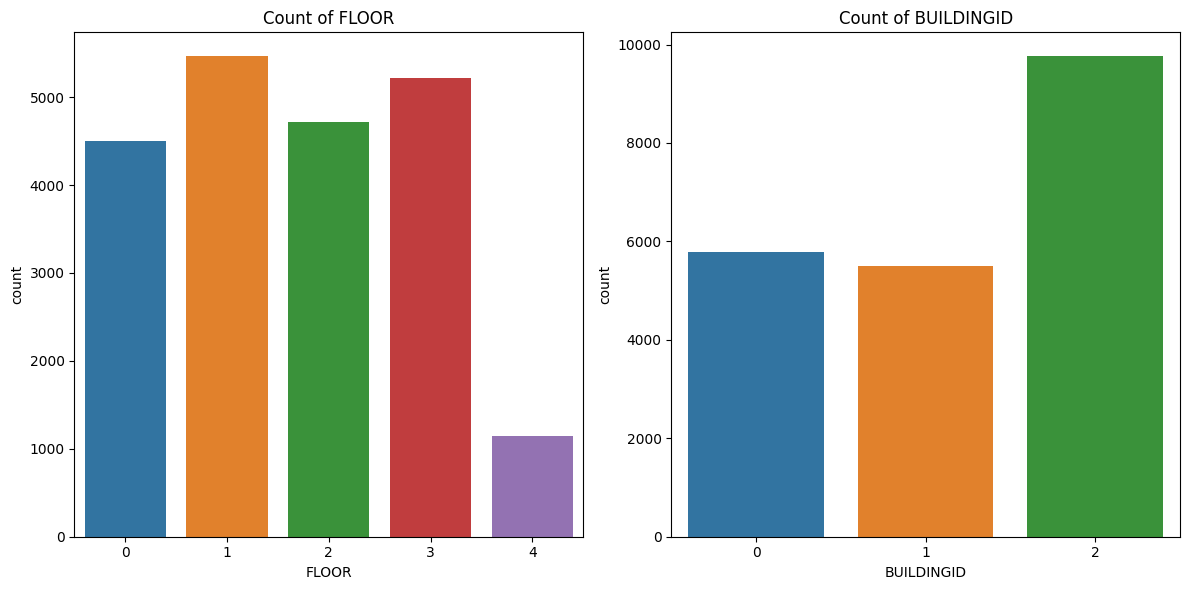

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x='FLOOR', data=new_data, ax=axes[0])
axes[0].set_title('Count of FLOOR')

sns.countplot(x='BUILDINGID', data=new_data, ax=axes[1])
axes[1].set_title('Count of BUILDINGID')

plt.tight_layout()
plt.show()

### **NORMALISATION OF DATA**

Aims to bring all features to a similar scale or range.

In [ ]:
def normalize(x, xmin, xmax, a, b):
    numerator = x - xmin        #difference between original value and min value
    denominator = xmax - xmin   #range of values in original set
    multiplier = b - a          # range of values in new set
    ans = (numerator / denominator) * multiplier + a #scaling and multiplying then adding to shift the desired value to new range
    return ans

If RSSI fingerprint is in between (-104 - 0) it is reachable and if it is represented by 100 it is not reachable. Normalising it to (0.25,1) for (-104 - 0) and keeping 0 for 100.

In [ ]:
sig_min = -104
sig_max = 0
tar_min = 0.25
tar_max = 1.0
no_sig = 100
def normalize_wifi(num):
    num = float(num)
    if math.isclose(num, no_sig, rel_tol=1e-3): #compare the values by keeping the relative tolerance
        return 0
    else:
        ans = normalize(num, sig_min, sig_max, tar_min, tar_max)
        return ans

In [ ]:
RSSI_data = new_data.columns[:520]


In [ ]:
# Normalize WiFi values
for i in RSSI_data:
    new_data[i] = new_data[i].apply(normalize_wifi)

In [ ]:
new_data

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7541.264300,4.864921e+06,2,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7536.621200,4.864934e+06,2,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7519.152400,4.864950e+06,2,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7524.570400,4.864934e+06,2,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7632.143600,4.864982e+06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7317.344231,4.864796e+06,3,2
1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7313.731120,4.864792e+06,3,2
1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7637.535798,4.864903e+06,0,0
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7636.654005,4.864905e+06,0,0


Latitude and Longitude values are normalized between 0 and 1.

In [ ]:
lat_min = 4864745.7450159714
lat_max = 4865017.3646842018
tarmin = 0
tarmax = 1
def normalize_lat(num):
    num = float(num)
    ans = normalize(num, lat_min, lat_max, tarmin, tarmax)
    return ans

In [ ]:
long_min = -7695.9387549299299000
long_max = -7299.786516730871000
tarmin = 0
tarmax = 1
def normalize_long(num):
    num = float(num)
    ans = normalize(num, long_min, long_max, tarmin, tarmax)
    return ans

In [ ]:
new_data["LATITUDE"] = new_data["LATITUDE"].apply(normalize_lat)
new_data["LONGITUDE"] = new_data["LONGITUDE"].apply(normalize_long)


### **SPLITTING THE DATA**

Splitting the dataset with test size as 15% of training.

In [ ]:
x = new_data[RSSI_data]
y = new_data[["LATITUDE", "LONGITUDE", "BUILDINGID", "FLOOR"]]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.15)

### **MODELS**

### Simple Neural Network as a sequential model.

Here we have Input layer followed by Dense layer and Output layer.We defined a series of fully connected (Dense) layers with varying numbers of units (neurons) and ReLU (Rectified Linear Unit) activation functions. The model is compiled using the 'adam' optimizer, which is a popular choice for training deep neural networks. The loss function is set to "mse" (Mean Squared Error) and additionally, it tracks the "accuracy" in each epoch.

In [ ]:
model = Sequential()
model.add(layers.Dense(519, activation="relu"))
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(4, activation="linear"))
model.compile(optimizer='adam',
                loss="mse", metrics=['accuracy'])

Fitting the model with validation split set of 20% and also visualising the accuracy and loss of the model.

In [ ]:
model.fit(x_train,y_train,epochs=10,batch_size=100, validation_split=0.2)

Epoch 1/10
144/144 [==============================] - 3s 13ms/step - loss: 0.1351 - accuracy: 0.8598 - val_loss: 0.0210 - val_accuracy: 0.9131
Epoch 2/10
144/144 [==============================] - 2s 12ms/step - loss: 0.0166 - accuracy: 0.9069 - val_loss: 0.0161 - val_accuracy: 0.9354
Epoch 3/10
144/144 [==============================] - 2s 12ms/step - loss: 0.0120 - accuracy: 0.9076 - val_loss: 0.0128 - val_accuracy: 0.9203
Epoch 4/10
144/144 [==============================] - 3s 19ms/step - loss: 0.0094 - accuracy: 0.9083 - val_loss: 0.0128 - val_accuracy: 0.9433
Epoch 5/10
144/144 [==============================] - 3s 19ms/step - loss: 0.0086 - accuracy: 0.9099 - val_loss: 0.0095 - val_accuracy: 0.9027
Epoch 6/10
144/144 [==============================] - 2s 13ms/step - loss: 0.0070 - accuracy: 0.9115 - val_loss: 0.0094 - val_accuracy: 0.9198
Epoch 7/10
144/144 [==============================] - 2s 13ms/step - loss: 0.0065 - accuracy: 0.9128 - val_loss: 0.0090 - val_accuracy: 0.9290

Making prediction on unseen data

In [ ]:
y_pred=model.predict(x_test)

99/99 [==============================] - 1s 4ms/step


Getting performance score on the unseen data and checking how weel the model fits to the real problem.

In [ ]:
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error: 0.044734374382245964
Mean Squared Error: 0.008531157817466987
Root Mean Squared Error: 0.09236426699469329
R-squared (R²): 0.9866723165725572


### Convolution Neural Network(CNN) model

Convolution Neural Network(CNN) model using Sequential API:
Here we have input layer implicitly defined with an input_shape of (520, 1) followed by Convolutional Layers contains three 1D convolutional layers and max-pooling layers.
Flatten Layer: added to transform the 3D output into a 1D vector. Dense layers are fully connected and intended for feature processing and representation.
Then we have output layer with same compiler.

In convolution layer we extract features based on the filters this results in high dim output so to reduce it we use Maxpool/avgpool. THis two are feature extraction part. Passing this to fully connected dense layer where each neuron is connected to each other.


In [ ]:
modelCNN = Sequential()

# Convolutional layers
modelCNN.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(520, 1)))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
modelCNN.add(MaxPooling1D(pool_size=2))

# Flatten the output for dense layers. Transforming the 3D tensor to 1D.
modelCNN.add(Flatten())

# Dense layers
modelCNN.add(Dense(512, activation='relu'))
modelCNN.add(Dense(256, activation='relu'))
modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(Dense(4, activation='linear'))
modelCNN.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

Fitting the model with validation split set of 20% and also visualising the accuracy and loss of the model.

In [ ]:
modelCNN.fit(x_train,y_train,epochs=10,batch_size=200, validation_split=0.2)

Epoch 1/10
72/72 [==============================] - 88s 1s/step - loss: 0.2283 - accuracy: 0.7902 - val_loss: 0.1134 - val_accuracy: 0.9050
Epoch 2/10
72/72 [==============================] - 81s 1s/step - loss: 0.0917 - accuracy: 0.9080 - val_loss: 0.0707 - val_accuracy: 0.8846
Epoch 3/10
72/72 [==============================] - 82s 1s/step - loss: 0.0737 - accuracy: 0.9078 - val_loss: 0.0648 - val_accuracy: 0.8958
Epoch 4/10
72/72 [==============================] - 81s 1s/step - loss: 0.0569 - accuracy: 0.9106 - val_loss: 0.0526 - val_accuracy: 0.8985
Epoch 5/10
72/72 [==============================] - 81s 1s/step - loss: 0.0473 - accuracy: 0.9114 - val_loss: 0.0550 - val_accuracy: 0.8765
Epoch 6/10
72/72 [==============================] - 82s 1s/step - loss: 0.0514 - accuracy: 0.9090 - val_loss: 0.0603 - val_accuracy: 0.9167
Epoch 7/10
72/72 [==============================] - 87s 1s/step - loss: 0.0472 - accuracy: 0.9092 - val_loss: 0.0501 - val_accuracy: 0.8642
Epoch 8/10
72/72 [==

Making prediction on unseen data.

In [ ]:
y_pred2=modelCNN.predict(x_test)

99/99 [==============================] - 5s 45ms/step


In [ ]:
# Calculate regression metrics
mae2 = mean_absolute_error(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse)
r22 = r2_score(y_test, y_pred2)

print("Mean Absolute Error:", mae2)
print("Mean Squared Error:", mse2)
print("Root Mean Squared Error:", rmse2)
print("R-squared (R²):", r22)

Mean Absolute Error: 0.031219793235714728
Mean Squared Error: 0.006939232129653077
Root Mean Squared Error: 0.09236426699469329
R-squared (R²): 0.9907725040186133


### CNN Model with less complex strucuture


The  input layer implicitly defined with an input_shape of (520, 1) followed by Convolutional Layers contains two 1D convolutional layers and max-pooling layers.
Flatten Layer: added to transform the 3D output into a 1D vector. Dense layers are fully connected and intended for feature processing and representation.
Then we have output layer with same compiler.

In convolution layer we extract features based on the filters this results in high dim output so to reduce it we use Maxpool/avgpool. THis two are feature extraction part. Passing this to fully connected dense layer where each neuron is connected to each other.


In [ ]:
modelCN = Sequential()

# Convolutional layers
modelCN.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(520, 1)))
modelCN.add(MaxPooling1D(pool_size=2))
modelCN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
modelCN.add(MaxPooling1D(pool_size=2))

# Flatten the output for dense layers. Transforming the 3D tensor to 1D.
modelCN.add(Flatten())

# Dense layers

modelCN.add(Dense(128, activation='relu'))
modelCN.add(Dense(4, activation='linear'))
modelCN.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

In [ ]:
modelCN.fit(x_train,y_train,epochs=10,batch_size=200, validation_split=0.2)

Epoch 1/10
72/72 [==============================] - 52s 700ms/step - loss: 0.2467 - accuracy: 0.7927 - val_loss: 0.1236 - val_accuracy: 0.8689
Epoch 2/10
72/72 [==============================] - 41s 571ms/step - loss: 0.1138 - accuracy: 0.8839 - val_loss: 0.1025 - val_accuracy: 0.8980
Epoch 3/10
72/72 [==============================] - 39s 536ms/step - loss: 0.0959 - accuracy: 0.8923 - val_loss: 0.0924 - val_accuracy: 0.8818
Epoch 4/10
72/72 [==============================] - 40s 553ms/step - loss: 0.0870 - accuracy: 0.8976 - val_loss: 0.0778 - val_accuracy: 0.8876
Epoch 5/10
72/72 [==============================] - 40s 560ms/step - loss: 0.0746 - accuracy: 0.9009 - val_loss: 0.0726 - val_accuracy: 0.9240
Epoch 6/10
72/72 [==============================] - 39s 546ms/step - loss: 0.0698 - accuracy: 0.9054 - val_loss: 0.0712 - val_accuracy: 0.8698
Epoch 7/10
72/72 [==============================] - 38s 527ms/step - loss: 0.0698 - accuracy: 0.9046 - val_loss: 0.0750 - val_accuracy: 0.9053

In [ ]:
y_predCN=modelCN.predict(x_test)

99/99 [==============================] - 4s 35ms/step


In [ ]:
# Calculate regression metrics
maeCN = mean_absolute_error(y_test, y_predCN)
mseCN = mean_squared_error(y_test, y_predCN)
rmseCN = np.sqrt(mseCN)
r2CN = r2_score(y_test, y_predCN)

print("Mean Absolute Error:", maeCN)
print("Mean Squared Error:", mseCN)
print("Root Mean Squared Error:", rmseCN)
print("R-squared (R²):", r2CN)

Mean Absolute Error: 0.05732664299767183
Mean Squared Error: 0.015317410850274306
Root Mean Squared Error: 0.12376352794856127
R-squared (R²): 0.9816748422739864


### K-Nearest Neighbors Regressor (KNN) model

K-Nearest Neighbors Regressor (KNN) model :
Here we define k-Nearest Neighbors (k-NN) algorithm for regression. Here prediction is based on similarity between input datapoint and K-nearest neighbour.We use scikit-learn machine learning library helps in creating an instance of the KNeighborsRegressor class.
Hyperparameter n_neighbors is set to 20, which means that the k-NN algorithm will consider the 20 nearest neighbors when making predictions.


Fitting the model with n_neighbours of 20 nearest neighbors to consider when making predictions and predicting on the unseen data.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=20)  # Example with k=20
knn.fit(x_train, y_train)
y_pred3 = knn.predict(x_test)

Getting performance score on the unseen data and checking how well the model fits to the real problem.

In [ ]:
mae3 = mean_absolute_error(y_test, y_pred3)
mse3 = mean_squared_error(y_test, y_pred3)
rmse3 = np.sqrt(mse)
r23 = r2_score(y_test, y_pred3)

print("Mean Absolute Error (MAE):", mae3)
print("Mean Squared Error (MSE):", mse3)
print("Root Mean Squared Error (RMSE):", rmse3)
print("R-squared (R²):", r23)

Mean Absolute Error (MAE): 0.02350145508607135
Mean Squared Error (MSE): 0.010319855833938988
Root Mean Squared Error (RMSE): 0.09236426699469329
R-squared (R²): 0.9882062690963179


### **PLOTS**

### Plotting the performance based the score described above

Text(0.5, 1.0, 'Different Model Fit Comaprison based on R-Square value')

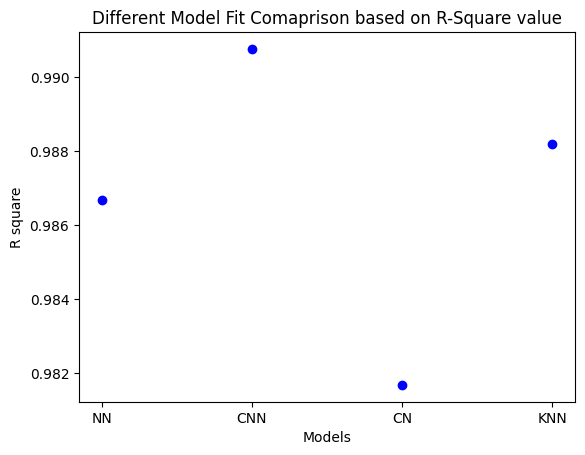

In [ ]:
# Create a scatter plot
plt.scatter(['NN','CNN','CN','KNN'], [r2, r22, r2CN, r23], label='Data Points', color='blue', marker='o')
plt.xlabel('Models')
plt.ylabel('R square')
plt.title('Different Model Fit Comaprison based on R-Square value')

Text(0.5, 1.0, 'Different Model Fit Comaprison based on MAE')

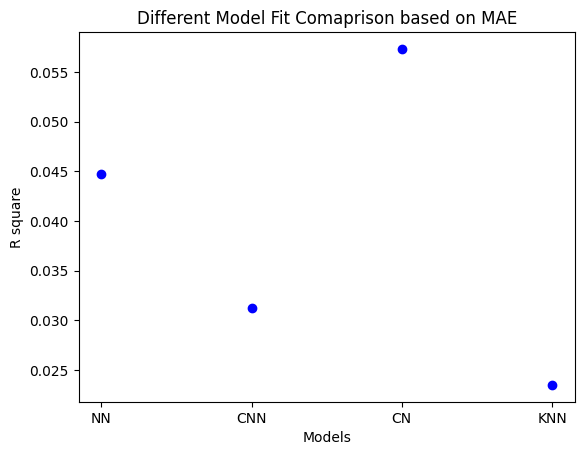

In [ ]:
plt.scatter(['NN','CNN','CN','KNN'], [mae, mae2, maeCN, mae3], label='Data Points', color='blue', marker='o')
plt.xlabel('Models')
plt.ylabel('R square')
plt.title('Different Model Fit Comaprison based on MAE')

Text(0.5, 1.0, 'Different Model Fit Comaprison based on MSE')

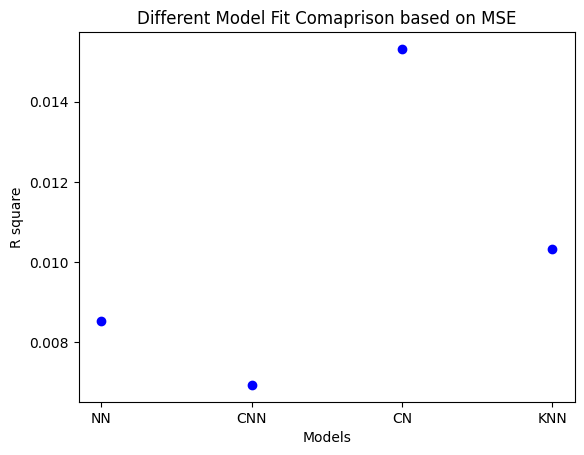

In [ ]:
plt.scatter(['NN','CNN','CN','KNN'], [mse, mse2, mseCN, mse3], label='Data Points', color='blue', marker='o')
plt.xlabel('Models')
plt.ylabel('R square')
plt.title('Different Model Fit Comaprison based on MSE')

Text(0.5, 1.0, 'Different Model Fit Comaprison based on RMSE')

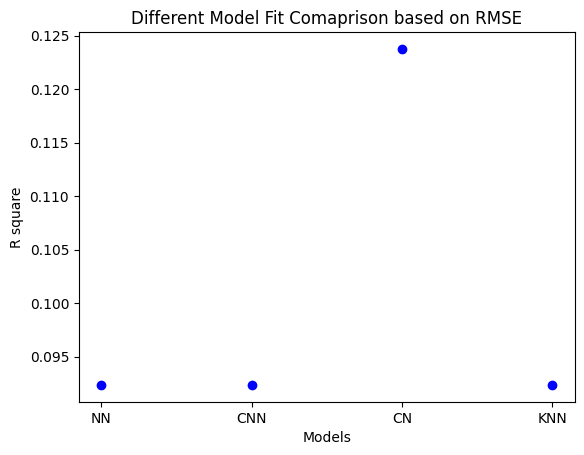

In [ ]:
plt.scatter(['NN','CNN','CN','KNN'], [rmse, rmse2,rmseCN, rmse3], label='Data Points', color='blue', marker='o')
plt.xlabel('Models')
plt.ylabel('R square')
plt.title('Different Model Fit Comaprison based on RMSE')